In [2]:
!pip install dask

In [5]:
import dask.dataframe as dd
import pandas as pd

def aggregate_time_values_dask(file_name, window_size, skip_blank_lines):
    """
    Aggregates time-based data from a large CSV file into specified time intervals using Dask.

    Parameters:
        file_name (str): Path to the input CSV file.
        window_size (int): The time window size (in seconds) for aggregation.

    Returns:
        pd.Series: A Series with time intervals as the index and record counts as values.
    """
    print("Working on dataset", file_name)


    df = dd.read_csv(
        f"../data/{file_name}",
        header=0,
        names=['time'],
        dtype={'time': str},
        skip_blank_lines=skip_blank_lines
    )


    df['time'] = df['time'].ffill().fillna('00:00:00.000')  
    df['time'] = dd.to_timedelta(df['time']) 

    df['time_bin'] = (df['time'].dt.total_seconds() // window_size) * window_size


    record_counts = df.groupby('time_bin').size().compute()  


    record_counts.index = pd.to_timedelta(record_counts.index, unit='s')

    full_range = pd.timedelta_range(
        start=record_counts.index.min(),
        end=record_counts.index.max(),
        freq=f'{window_size}S'
    )
    record_counts = record_counts.reindex(full_range, fill_value=0)

    return record_counts

/home/kohsuke/python-notebook/my_virtual_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
record_counts_08 = aggregate_time_values_dask("debs2022-gc-trading-day-08-11-21-timestamps.csv",1, True)
record_counts_09 = aggregate_time_values_dask("debs2022-gc-trading-day-09-11-21-timestamps.csv",1, True)
record_counts_10 = aggregate_time_values_dask("debs2022-gc-trading-day-10-11-21-timestamps.csv",1, True)
record_counts_11 = aggregate_time_values_dask("debs2022-gc-trading-day-11-11-21-timestamps.csv",1, True)
record_counts_12 = aggregate_time_values_dask("debs2022-gc-trading-day-12-11-21-timestamps.csv",1, True)

Working on dataset debs2022-gc-trading-day-08-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-09-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-10-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-11-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-12-11-21-timestamps.csv


In [10]:
#show basic analysis data
datasets = {
    "08_11_21": record_counts_08,
    "09_11_21": record_counts_09,
    "10_11_21": record_counts_10,
    "11_11_21": record_counts_11,
    "12_11_21": record_counts_12,
}

def calculate_summary(data):
    return {
        "mean": round(data.mean()),
        "std": round(data.std()),
        "50%": int(data.quantile(0.5)),
        "70%": int(data.quantile(0.7)),
        "95%": int(data.quantile(0.95)),
        "max": round(data.max()),
    }


summaries = {name: calculate_summary(data) for name, data in datasets.items()}
summary_df = pd.DataFrame(summaries).T  


order = ["mean", "std", "50%", "70%", "95%","max"]
summary_df = summary_df[order]


print(summary_df)
print(summary_df.shape)


          mean  std  50%  70%   95%   max
08_11_21   332  584    0  474  1187  7477
09_11_21   352  613    0  492  1323  7936
10_11_21   374  628    0  569  1293  8292
11_11_21   335  586    0  489  1214  7888
12_11_21   336  584    0  489  1190  7392
(5, 6)


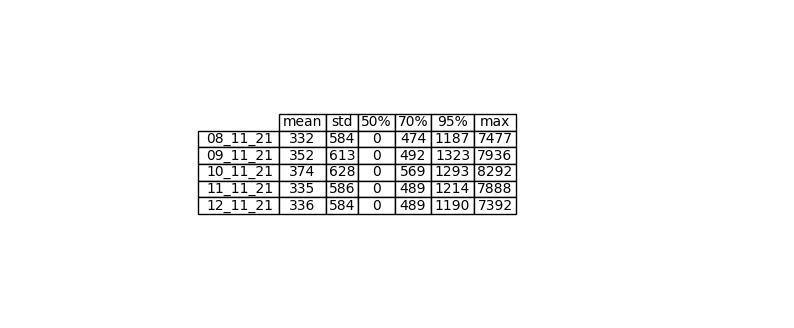

In [11]:
# preserve table as png
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))  
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    rowLabels=summary_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))

plt.savefig("analysis_table_without_missing.png", bbox_inches='tight', dpi=300)
plt.show()

In [12]:
file_paths = [
    ("08_11_21", "debs2022-gc-trading-day-08-11-21-timestamps.csv"),
    ("09_11_21", "debs2022-gc-trading-day-09-11-21-timestamps.csv"),
    ("10_11_21", "debs2022-gc-trading-day-10-11-21-timestamps.csv"),
    ("11_11_21", "debs2022-gc-trading-day-11-11-21-timestamps.csv"),
    ("12_11_21", "debs2022-gc-trading-day-12-11-21-timestamps.csv"),
]

def calculate_summary(data):
    return {
        "mean": round(data.mean()),
        "std": round(data.std()),
        "50%": int(data.quantile(0.5)),
        "70%": int(data.quantile(0.7)),
        "95%": int(data.quantile(0.95)),
        "max": round(data.max()),
    }

summary_list = []

for label, path in file_paths:
    record_counts = aggregate_time_values_dask(path, 1, False)
    
    summary = calculate_summary(record_counts)
    
    summary["label"] = label
    summary_list.append(summary)


summary_df = pd.DataFrame(summary_list)


order = ["label", "mean", "std", "50%", "70%", "95%","max"]
summary_df = summary_df[order]

print(summary_df)
print(summary_df.shape)


Working on dataset debs2022-gc-trading-day-08-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-09-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-10-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-11-11-21-timestamps.csv
Working on dataset debs2022-gc-trading-day-12-11-21-timestamps.csv
      label  mean   std  50%   70%   95%    max
0  08_11_21   664  1057    0  1011  2653  57975
1  09_11_21   723  1149    0  1080  3086  47449
2  10_11_21   794  1209    0  1282  3162  43645
3  11_11_21   683  1068    0  1072  2763  36788
4  12_11_21   690  1075    0  1078  2751  47347
(5, 7)


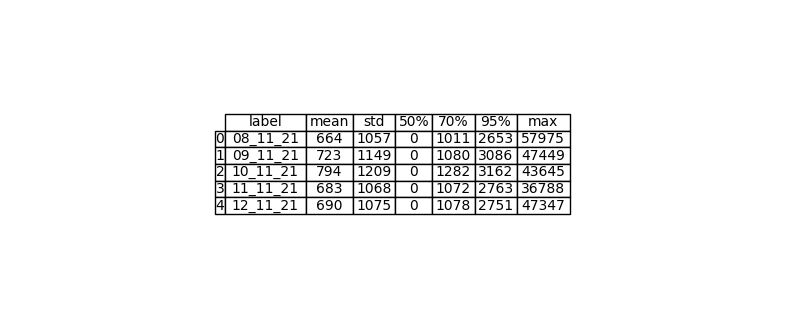

In [13]:
# preserve table as png
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))  
ax.axis('tight')
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    rowLabels=summary_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))

plt.savefig("analysis_table.png", bbox_inches='tight', dpi=300)
plt.show()